<a href="https://colab.research.google.com/github/sanda-avram/Transformers-on-ROST/blob/main/FillMask/ROST_FillMask_distilbert-base-multilingual-cased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [5]:
from datasets import Dataset
import pandas as pd
train_df=messages = pd.read_csv('trainSet1.csv', sep=',', names=["label", "text"])
test_df=messages = pd.read_csv('testSet1.csv', sep=',', names=["label", "text"])


train_ds = Dataset.from_pandas(train_df, split="train")
test_ds = Dataset.from_pandas(test_df, split="test")

model_name = "distilbert-base-multilingual-cased"

In [ ]:
!pip install transformers

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_ds.map(tokenize_function, batched=True)
test_dataset = test_ds.map(tokenize_function, batched=True)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [9]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=10)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'pre_classifie

In [10]:
!pip install evaluate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 4.0 MB/s eta 0:00:00


In [11]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="testTrainer", evaluation_strategy="epoch")

In [12]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [13]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5411
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2031
  Number of trainable parameters = 135332362


Epoch,Training Loss,Validation Loss,Accuracy
1,1.739400,1.405654,0.517945
2,1.124200,0.984673,0.695285
3,0.400500,0.923689,0.735398


Saving model checkpoint to testTrainer/checkpoint-500
Configuration saved in testTrainer/checkpoint-500/config.json
Model weights saved in testTrainer/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1421
  Batch size = 8
Saving model checkpoint to testTrainer/checkpoint-1000
Configuration saved in testTrainer/checkpoint-1000/config.json
Model weights saved in testTrainer/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evalu

TrainOutput(global_step=2031, training_loss=0.9755394215773973, metrics={'train_runtime': 140.4956, 'train_samples_per_second': 115.541, 'train_steps_per_second': 14.456, 'total_flos': 1075325034470400.0, 'train_loss': 0.9755394215773973, 'epoch': 3.0})

In [14]:
trainer.evaluate(trainer.eval_dataset)

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1421
  Batch size = 8


{'eval_loss': 0.9236894845962524,
 'eval_accuracy': 0.7353976073187896,
 'eval_runtime': 3.1258,
 'eval_samples_per_second': 454.597,
 'eval_steps_per_second': 56.945,
 'epoch': 3.0}

In [15]:
predicted=trainer.predict(test_dataset)

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1421
  Batch size = 8


In [16]:
c=0
y=[]
for v in predicted.predictions:
  c+=1

  max = v[0]
  index = 0
  for i in range(1,len(v)):
    if v[i] > max:
      max = v[i]
      index = i
  y.append(index)

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
cm=confusion_matrix(test_dataset['label'], y)
print(cm)
accuracy = accuracy_score(test_dataset['label'], y)
print("accuracy:", accuracy)
# Calculate macro-accuracy
#macro_accuracy = np.mean(np.diag(cm))

#print("Macro-accuracy:", macro_accuracy/10)
from sklearn.metrics import classification_report

print(classification_report(test_dataset['label'], y, digits=3))

[[ 59   1   1   0   1   5   0   0   2   5]
 [  8 140   5  21   4   2   0   4  29   3]
 [  3  10 199   5   1   0   0   2  20   2]
 [  1   6   4  62   0  11   0   0   0   2]
 [  9   4   2   0   6   0   0   1  11   1]
 [ 12   2   2   4   1 148   0   0   3  13]
 [  0   3   0   0   0   0   0   4  12   6]
 [  0   2   0   0   0   1   0  61  10   3]
 [  7  14   7   0   6   2   0   9 114  17]
 [  5   2   3   8   3  26   0   2   1 256]]
accuracy: 0.7353976073187896
              precision    recall  f1-score   support

           0      0.567     0.797     0.663        74
           1      0.761     0.648     0.700       216
           2      0.892     0.822     0.856       242
           3      0.620     0.721     0.667        86
           4      0.273     0.176     0.214        34
           5      0.759     0.800     0.779       185
           6      0.000     0.000     0.000        25
           7      0.735     0.792     0.762        77
           8      0.564     0.648     0.603       176

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(test_dataset['label'], y)

0.6241696687950263

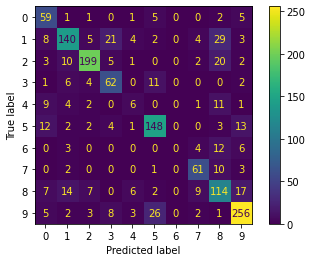

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
 

In [ ]:
!kill 7123
%reload_ext tensorboard
%tensorboard --logdir ./testTrainer/
